# Interior Point Methods For Linear Problems

In this text, we will present alternative methods for the Simplex algorithm for solving linear problems. While Dantzig's simplex searches for solutions in the border of the feasible region, the so-called Interior Point methods follows its iterations inside the feasible region.

Introducing the notation, our primal linear program will be:

\begin{align*}
&\min_{x} c^T x\\
\text{s. t. }&Ax=b\\
&x\geq 0
\end{align*}

where $A$ is an $m\times n$ matrix, and its dual version:

\begin{align*}
&\max_{p} b^T p\\
\text{s. t. }&A^Tp\leq c\end{align*}

We introduce two different algorithms, show the theory behind them, and compare their implementations in Julia.

## Affine Scaling Algorithm

Affine Scaling is the most classical interior point algorithm. Instead of optimizing over the entire feasible region, we'll reduce the feasibility to an ellipsoid contained in it, then we can find an analytical solution, and iterate this whole process until we reach the optimal value within a tolerance that is calculated through the duality gap. The optimal value of an iteration is used as the center of the next feasible ellipsoid.

### Theory 

Define the feasible region as $F=\{x\in \mathbb{R}^n|Ax=b,x\geq0\}$, the subset of $F$ $\{x\in F|x>0\}$ is called the set of interior points.

Given $y>0$ a feasible and interior solution, the following lemma establishes a feasible ellipsoid $S$ centered in $y$.

**Lemma 1:** Let $\beta\in(0,1)$ and $y>0$ and

$$S=\Big\{x\in\mathbb{R}^n\big|\sum_{i=1}^n\dfrac{(x_i-y_i)^2}{y_i^2}\leq\beta^2\Big\},$$

then if $x\in S$ then $x>0$.

**Proof:** For a given $x\in S$, we have for each $x_i$:

$(x_i-y_i)^2\leq y_i^2\beta^2<y_i^2$, and since $y_i>0$ we can take the square root and get $|x_i-y_i|< y_i$ which implies $y_i-x_i< y_i$, where we conclude $x_i>0$. **Q.E.D**

If we define $Y=diag(y_1,\ldots,y_n)$ i.e, a diagonal matrix where the i-th entry is $y_i$, we can rewrite the ellipsoid inequation as:

$$||Y^{-1}(x-y)||\leq\beta$$

We can now redefine the problem to minimize over $S$:

\begin{align*}
&\min_{x} c^T x\\
\text{s. t. }&Ax=b\\
&||Y^{-1}(x-y)||\leq\beta
\end{align*}

Since $y$ is feasible, $Ay=b$, and we can define a new variable $d=x-y$, and modify the problem again:

\begin{align*}
&\min_{x} c^T d\\
\text{s. t. }&Ad=0\\
&||Y^{-1}d||\leq\beta
\end{align*}

The following lemma states an analytical solution for this problem guaranteeing that the optimal step $d$ keeps the point in the feasible set and the objective function is strictly minimized.

**Lemma 2:** Assume $rank(A)=m$ and that $c\notin span(A)$. Given $y>0$ the optimal solution of the above LP is:

$$d^*=-\beta\dfrac{Y^2(c-A^Tp)}{||Y(c-A^Tp)||},$$

where 

$$p=(AY^2A^T)^{-1}AY^2c.$$

Furthermore, $x = y +d^*$ belongs to the feasible set $F$, and 

$$c^Tx<c^Ty$$

**Proof:** The rank and span conditions in $A$ are linear algebra details to guarantee that $AY^2A^T$ is invertible and $p$ and $d^*$ are well-defined. Such details can be found in [[2]](#References), here we'll prove the feasibility and optimality of $d^*$ without worrying about this.

To prove feasibility we need: $Ad^*=0$ and $||Y^-1d^*||\leq\beta$, for the first, we just need to show that $AY^2(c-A^Tp)=0:$

\begin{align*}
AY^2(c-A^Tp)&=AY^2(c-A^T(AY^2A^T)^{-1}AY^2c)\\
&=AY^2(c-A^T(A^T)^{-1}Y^{-2}A^{-1}AY^2c)\\
&=AY^2(c-Y^{-2}Y^2c)\\
&=AY^2(c-Ic)\\
&=0
\end{align*}

Since $Y^{-1}d^*=\beta\dfrac{Y(c-A^Tp)}{||Y(c-A^Tp)||}$, we can easily see that $||Y^{-1}d^*||=\beta$, satisfying the constraint inequality.

To prove optimatily, we take a feasible $d$, i.e, $Ad=0$ and $||Y^{-1}d||\leq\beta$. Using this and Schwarz inequality we can get:

\begin{align*}
c^Td&=(c^T-p^TA)d\\
&=(c^T-p^TA)YY^{-1}d\\
&=(c-A^Tp)^TYY^{-1}d\\
&\geq-||Y(c-A^Tp)||\cdot||Y^{-1}d||\\
&\geq-\beta||Y(c-A^Tp)||
\end{align*}

One can prove using the same strategy that $c^Td^*=-\beta||Y(c-A^Tp)||$, proving that $d^*$ is optimal. Furthermore, the objective function is reduced:

\begin{align*}c^Tx&=c^T(y+d^*)\\&=c^Ty+c^Td^*\\&=c^Ty-\beta||Y(c-A^Tp)||\\&<c^Ty\end{align*}

The feasibility of $x=y+d^*$ follows from Lemma 1.

The reference [2](#References) also show that the $p$ from Lemma 2 is the dual feasible solution for $y$. Then can write the duality gap as:

\begin{align*}
c^Ty-b^Tp&=c^Ty-(Ay)^Tp\\
&=c^Ty-y^TA^Tp\\
&=y^T(c-A^Tp)
\end{align*}

We define $s=(c-A^Tp)$ as the dual slackness. Such a simple formula for the gap as $y^Ts$ give us direct way for computing stopping conditions, using minimum tolerance $\varepsilon$ for this gap.

The algorithm starts with a feasible solution $x^{(0)}$, computes the optimal value inside the ellipsoid centered at $x^{(0)}$ using the above concepts, and uses this value as the center for the next ellipsoid until we reach the duality gap tolerance.

### Implementation

**Inputs:** 

- the problem $(A,b,c)$
- initial primal feasible value $x^{(0)}>0$
- optimality tollerance $\varepsilon$
- $\beta\in(0,1)$

**1. (Initialization)** Starts iteration k=0, with the initial solution

**2. (Dual Slackness computation)** Given $x^{(k)}>0$, sets

\begin{align*}X_k&=diag(x^{(k)}_1,\ldots,x^{(k)}_n)\\
p_k&=(AX_k^2A^T)^{-1}AX_k^2c\\
s_k&=c-A^Tp_k\end{align*}

**3. (Optimatily check)** If $s_k>0$ and $s_k^Tx^{(k)}<\varepsilon$, the stops the algorithm and outputs $x^{(k)}$ as the primal approximate optimal solution.

**4. (Solution update)** Set

$$x^{(k+1)}=x^{(k)}-\beta \dfrac{X^2_ks_k}{||X_ks_k||}$$

An code implementation in Julia 1.7.3, can be found in the file [affine_scalling.jl](https://github.com/reneroliveira/interior-point-methods/blob/main/affine_scaling.jl), from the Reference [[1]](#References).

### Example

We're going to use the following example (already in SEF):

$$A=\begin{bmatrix}1&2&1&0\\2&1&0&1\end{bmatrix},b=\begin{bmatrix}3\\3\end{bmatrix}\text{ and }c=\begin{bmatrix}-1\\-1\\0\\0\end{bmatrix}$$

The initial condition will be the point $(0.5,0.03)$, and the corresponding vector with slackness is:

$$x^{(0)}=(0.5,0.03,2.44,1.97)$$

We'll use the parameters $\beta=0.5,\varepsilon=10^{-9}$

In Julia, we can use the function and plot the trajectories:

Optimal Solution:
(0.9999998849647512,1.0000000877494506)

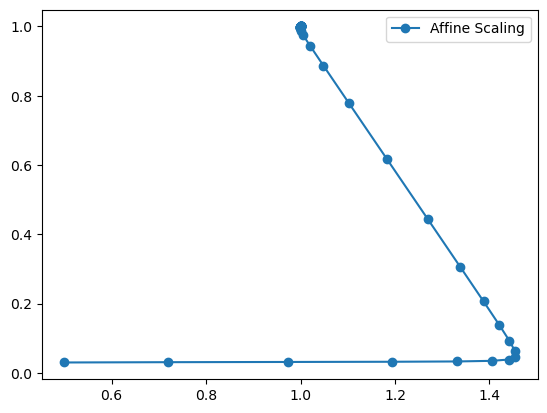

In [95]:
using LinearAlgebra
using PyPlot
include("affine_scaling.jl")

A = [1 2 1 0 ;
     2 1 0 1 ]
b = [3, 3]
c = [-1, -1, 0, 0]


# Initial Starting Solution
x0 = [0.5, 0.03, 2.44, 1.97]

x1_traj, x2_traj = affine_scaling(c, A, b, x0,beta = 0.5, epsilon =1e-9)
fig = figure()
plot(x1_traj, x2_traj, "o-", label="Affine Scaling")
legend(loc="upper right")

println("Optimal Solution:")
println("(",x1_traj[end],",",x2_traj[end],")")

## Primal-Dual Path Following Algorithm

The ideia behind this algorithm is to remove the positiveness constraint and modify the objective function so as to penalize variables that falls outside the feasible region. This penalization is controlled by a parameter $\mu$, in such way that as $\mu\to0$ we get converge to the original problem. Using this, we solve the modified problem using KKT conditions equations (by Newton's method) and use the optimal value as an initial solution to the next iterarion using a smaller $\mu$. That's the summary of the algorithm, details will be more clear in the next subsections.

Consider the problem:

\begin{align*}
&\min_{x} c^T x\\
\text{s. t. }&Ax=b\\
&x\geq 0
\end{align*}

and its dual version with slackness $s$

\begin{align*}
&\max_{p} b^T p\\
\text{s. t. }&A^Tp+s= c\\
&~~~~~~~~~s\geq0\end{align*}

### The barrier problem

For a given $\mu>0$ let's introduce the barrier function:

$$B_{\mu}(x)=c^Tx-\mu\sum_{j=1}^{n}\log x_j$$

We can set $B_{\mu}(x)=+\infty$ if some $x_j\leq 0$

The (primal) barrier problem is:

\begin{align*}
&\min_{x} B_{\mu}(x)\\
\text{s. t. }&Ax=b
\end{align*}

Although we removed the positiveness constraint, the new objective increases as the vector $x$ approaches the zero in some direction, i.e, we are rewarding the function if $x$ stays in the feasible region. If we take a big value of $\mu$, the term $c^Tx$ is neglected and the optimal solution will be a feasible $x$ such that, the penalization $-\mu\sum_{j=1}^{n}\log x_j$ is minimized. Such $x$ value is called the "analytical center" of the feasible region. Oppositely, if $\mu$ approaches 0, and $x(\mu)$ is the optimal solution to the barrier problem, it can be shown that $\lim_{\mu\to0}x(\mu)$ exists and is an optimal solution for the original problem, intuitively, because the penalization term is small enough.

Let $\mu_0,\mu_1,\mu_2,\ldots$ be a strictly decreasing sequence of positive values with $\lim_{k\to\infty}\mu_k=0$, and $x(\mu_k)$ be the optimal solution for the barrier problem with objective  $B_{\mu_k}(x)$. The sequence:

$$x(\mu_0),x(\mu_1),x(\mu_2)\ldots$$

is called the **central path**, and converges to the optimal solution. That's tha path the algorithm will follow, but now we have a new problem: How do optimize $B_{\mu}(x)$? 

### KKT Conditions

Previously we describe a barrier problem for the original primal problem, we can do the same thing for the dual one:

\begin{align*}
&\max_{p} b^Tp+\mu\sum_{j=1}^n\log(x_j)\\
\text{s. t. }&A^Tp+s=c
\end{align*}

Let $x(\mu)$ be a feasible solution for the primal barrier problem and $p(\mu),s(\mu)$ feasible solutions for the dual barrier one. It can be shown [[2]](#References) that, if $x(\mu),p(\mu),s(\mu)$ satiffies the below listed KKT (Karush–Kuhn–Tucker) conditions, they are optimal.

\begin{align*}
Ax(\mu)b&=0\\
x(\mu)&\geq0\\
A^Tp(\mu)+s(\mu)&=c\\
s(\mu)&\geq0\\
x_js_j&=\mu
\end{align*}

where the last condition holds for $j=1,\ldots,n$, and can be rewrited as $X(\mu)S(\mu)e=e\mu$, where $X(\mu)=diag(x_1(\mu),\ldots,x_n(\mu))$, $S(\mu)=diag(s_1(\mu),\ldots,s_n(\mu))$, and $e$ is a column vector of ones.

Since KKT conditions garantees optimality for the $\mu$-barrier problem, we can reduce our task of finding $x(\mu),p(\mu),s(\mu)$ to solving the KKT equations, but the last equation $x_js_j$ is nonlinear, which makes it difficult do solve directly, so we'll use Newton's method, an iterative algorithm for root fiding of nonlinear functions.

### Newton's Method and Implementation

Let $F:\mathbb{R}^n\to\mathbb{R}^n$ be a map where we want to find $z^*$ such that $F(z^*)=0$.

Suppose we have an approximation of the solution $z^k$ and want to improve it. We can use the first order Taylor Expansion:

$$F(z^k+d)\approx F(z^k)+J(z^k)d,$$

where $J(z^k)$ is the Jacobian, an $n\times n$ matrix which i-th row and j-th column is:

$$\dfrac{\partial F_i(z)}{\partial z_j}\Big|_{z=z^k}$$

We're looking for some $d$ s.t $F(z^k+d)=0$, but we can use the taylor approximation to solve the system:

$$F(z^k)+J(z^k)d$$

Then we set $z^{k+1}=z^{k}+d$ and repeat the process until convergence.

In our case of KKT equations, we have a vector $z=(x,p,s)$ and $F(z)$ given by the below $(2n+m)$-square-matrix:

$$F(z)=\begin{bmatrix}Ax-b\\A^Tp+s-c\\XSe-\mu e\end{bmatrix}$$

Suppose we have a feasible vector $(x^k,p^k,s^k)$, to find Newton's direction $d=(d_x^k,d_p^k,d_s^k)$, we can solve the system:

$$\begin{bmatrix}A &\boldsymbol 0 &\boldsymbol 0\\
\boldsymbol 0&A^T& I\\
S_k&\boldsymbol0&X_k\end{bmatrix}\begin{bmatrix}d_x^k\\d_p^k\\d_s^k\end{bmatrix}=-\begin{bmatrix}Ax^k-b\\A^Tp^k+s^k-c\\X_kS_k e-\mu^k e\end{bmatrix}$$

Reference [[2]](#References) shows the analytical solution for $d$ but this is enough for us now, since we'll use Julia Linear Algebra package to solve the system for us.

Now we have the direction to update the solutions, we have to decide the step length.

\begin{align*}
x^{k+1} &= x^k+\beta_P^kd_x^k\\
p^{k+1} &= p^k+\beta_D^kd_p^k\\
s^{k+1} &= s^k+\beta_D^kd_s^k
\end{align*}

the lengths are choosen in order to preserve feasibility:

\begin{align*}
\displaystyle \beta_P^k &= \min\Big\{1,\alpha\cdot\min_{i|(d_x^k)_i<0}\left(-\dfrac{x_i^k}{(d_x^k)_i}\right)\Big\}\\
\displaystyle \beta_D^k &= \min\Big\{1,\alpha\cdot\min_{i|(d_s^k)_i<0}\left(-\dfrac{s_i^k}{(s_x^k)_i}\right)\Big\},
\end{align*}

where $\alpha\in(0,1)$.

If we proceed with Newton's iterations with a fixed $\mu^k$ we'll converge to a solution in the central path for the modified $\mu_k$-barrier problem, but since we don't want such solutions, we decrease $\mu^k$ in each step, and use the previos Newton's solution as initial step for the new iteration with smaller $\mu^k$. A good choice of $\mu^k$ is:

$$\mu^k=\rho_k\dfrac{(x^k)^Ts^k}n,$$

where $\rho_k\leq1$. In our program we fixed $\rho_k=1/2$ for all steps.

The Julia Implementation can be found in [primal_dual_path_following.jl](https://github.com/reneroliveira/interior-point-methods/blob/main/primal_dual_path_following.jl) file.

### Example

We used the same example as before, but now using the Primal-Dual algorithm.

Optimal Solution:
(0.9999999998408018,0.9999999998408022)


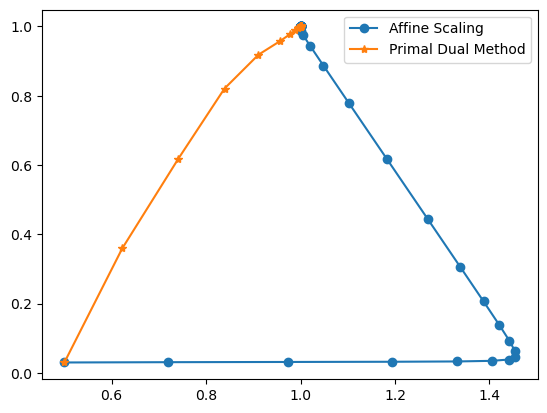

In [105]:
using PyPlot
include("primal_dual_path_following.jl")

A = [1 2 1 0 ;
     2 1 0 1 ]
b = [3, 3]
c = [-1, -1, 0, 0]


# Initial Starting Solution
x0 = [0.5, 0.03, 2.44, 1.97]
p0=[-1 ; -1]

x1_traj, x2_traj = affine_scaling(c, A, b, x0,beta = 0.5, epsilon =1e-9)
x1_traj_pd, x2_traj_pd = primal_dual(c,A,b,x0,p0; epsilon=1e-9, max_iter=1000,alpha=0.9)

fig = figure()
plot(x1_traj, x2_traj, "o-", label="Affine Scaling")
plot(x1_traj_pd, x2_traj_pd, "*-", label="Primal Dual Method")
legend(loc="upper right");

println("Optimal Solution:")
println("(",x1_traj_pd[end],",",x2_traj_pd[end],")")

## References 

[1] Kwon, C. (2019). Julia Programming for Operations Research 2/e. Softcover.Io. https://www.softcover.io/read/7b8eb7d0/juliabook2/interior#cid40

[2] Bertsimas, D., Tsitsiklis, J. N., & Tsitsiklis, J. (1997). Introduction to Linear Optimization (Athena Scientific Series in Optimization and Neural Computation, 6) (1st ed.). Athena Scientific.